In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PixelCNN import PixelCNN
from torch.autograd import Variable
import torch.nn.functional as F
#tqdm
from tqdm import tqdm

train_ds = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=100, shuffle=False)

device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

model = PixelCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epochs = 5, train_loader = train_loader):
    
    for epoch in range(epochs):
        model.train()

        train_loader = tqdm(train_loader)

        for images, labels in train_loader:
            
            target = target = Variable(images[:,0,:,:]*255).long()
            images = images.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, target)

            correct = (output == images).float()
            accuracy = correct.sum() / images.numel()
            # debug this


            loss.backward()
            optimizer.step()

            train_loader.set_description(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}')


In [2]:
train(epochs=5, train_loader=train_loader)
torch.save(model.state_dict(), 'PixelCNN.pt')

Epoch: 5/5, Loss: 0.7698, Accuracy: 0.00: 100%|██████████| 600/600 [00:14<00:00, 41.60it/s]


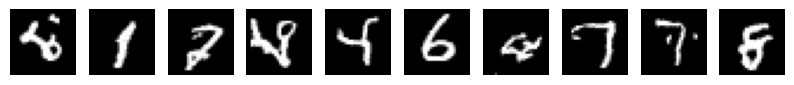

In [5]:
model = PixelCNN().to(device)
model.load_state_dict(torch.load('PixelCNN.pt'))
model.eval()

from matplotlib import pyplot as plt

def generate_and_plot(model, count = 10):
	sample = torch.Tensor(count, 1, 28, 28).to(device)
	sample.fill_(0)
    #Generating images pixel by pixel
	for i in range(28):
		for j in range(28):
			out = model(sample)
			probs = F.softmax(out[:,:,i,j], dim=-1).data
			sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0

	# plot the images

	plt.figure(figsize=(10, 10))

	for i in range(count):
		plt.subplot(1, count, i+1)
		plt.imshow(sample[i,0,:,:].cpu().numpy(), cmap='gray')
		plt.axis('off')

generate_and_plot(model, count=10)